<a href="https://www.kaggle.com/code/nosanesrine/gan-for-data-augmentation-mnist?scriptVersionId=242706777" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Step 1: Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


2025-05-30 09:47:00.005835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 09:47:00.005977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 09:47:00.136649: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Step 2: Load and Preprocess MNIST Data**

In [3]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

x_test = (x_test.astype(np.float32) - 127.5) / 127.5
x_test = np.expand_dims(x_test, axis=-1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
print(x_train.shape)

(60000, 28, 28, 1)


In [5]:
print(x_test.shape)

(10000, 28, 28, 1)


# Step 3: Build the GAN
3.1 Generator Model

In [6]:
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model


3.2 D**iscriminator Model**

In [7]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


**3.3 Compile GAN**

In [8]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Create the GAN by stacking the generator and the discriminator
discriminator.trainable = False
gan = Sequential([generator, discriminator])

# Compile the GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Step 4: Train the GAN**

In [9]:
def train_gan(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")
            save_imgs(epoch)

def save_imgs(epoch, n=10):
    noise = np.random.normal(0, 1, (n * n, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images to [0, 1]

    fig, axs = plt.subplots(n, n)
    cnt = 0
    for i in range(n):
        for j in range(n):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  


I0000 00:00:1748598432.356351      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.682553231716156 | D accuracy: 64.453125] [G loss: [array(0.6869222, dtype=float32), array(0.6869222, dtype=float32), array(0.5859375, dtype=float32)]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


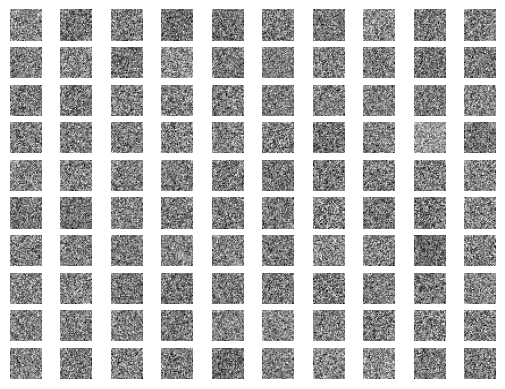

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

In [10]:
train_gan(epochs=1000, batch_size=64, save_interval=1000)

# Step 5: Prepare Augmented Data

In [11]:
def generate_augmented_data(generator, n_samples):
    noise = np.random.normal(0, 1, (n_samples, 100))
    gen_imgs = generator.predict(noise)
    return gen_imgs

# Generate additional images
n_generated_samples = 60000  # Number of generated samples
generated_images = generate_augmented_data(generator, n_generated_samples)

# Combine the original and generated images
x_combined = np.concatenate((x_train, generated_images))
y_combined = np.concatenate((y_train, np.full((n_generated_samples,), -1)))  # Assign a placeholder label for generated images


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [12]:
print(x_combined.shape)

(120000, 28, 28, 1)


# Step 6: Build and Train the CNN Classifier
6.1 CNN Model

In [13]:
def build_cnn():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model


#  Compile and Train CNN

In [14]:
cnn = build_cnn()
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Filter out the generated images for training the classifier
train_filter = y_combined != -1
x_combined_filtered = x_combined[train_filter]
y_combined_filtered = y_combined[train_filter]

# Train the CNN
#cnn.fit(x_combined_filtered, y_combined_filtered, epochs=5, batch_size=64, validation_data=(x_test, y_test))
cnn.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5


2025-05-30 09:56:20.404811: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 676: 2.01985, expected 1.26858
2025-05-30 09:56:20.404877: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 677: 2.17255, expected 1.42128
2025-05-30 09:56:20.404896: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 678: 2.62646, expected 1.87519
2025-05-30 09:56:20.404911: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 679: 2.17504, expected 1.42377
2025-05-30 09:56:20.404929: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 680: 2.46212, expected 1.71085
2025-05-30 09:56:20.404954: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 681: 2.56704, expected 1.81578
2025-05-30 09:56:20.404967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 682: 2.12676, expected 1.3755
2025-05-30 09:56:20.404979: E external/loc

929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9062 - loss: 0.3214

2025-05-30 09:56:25.108363: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.35363, expected 1.53764
2025-05-30 09:56:25.108440: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.82107, expected 1.00508
2025-05-30 09:56:25.108451: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.81936, expected 1.00338
2025-05-30 09:56:25.108458: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.23827, expected 1.42229
2025-05-30 09:56:25.108466: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.05481, expected 2.23883
2025-05-30 09:56:25.108474: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.58554, expected 1.76955
2025-05-30 09:56:25.108482: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.00002, expected 2.18403
2025-05-30 09:56:25.108489: E external/local_xla/xla/se

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9067 - loss: 0.3196

2025-05-30 09:56:27.072736: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.34972, expected 1.00161
2025-05-30 09:56:27.072792: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.6774, expected 1.32929
2025-05-30 09:56:27.072802: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.95868, expected 1.61057
2025-05-30 09:56:27.072810: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.69333, expected 1.34521
2025-05-30 09:56:27.072818: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.08558, expected 1.73747
2025-05-30 09:56:27.072826: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.59326, expected 1.24515
2025-05-30 09:56:27.072833: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 1.72639, expected 1.37827
2025-05-30 09:56:27.072841: E external/local_xla/xla/ser

938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9068 - loss: 0.3194 - val_accuracy: 0.9841 - val_loss: 0.0515
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9763 - loss: 0.1004 - val_accuracy: 0.9879 - val_loss: 0.0358
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9804 - loss: 0.0973 - val_accuracy: 0.9874 - val_loss: 0.0430
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9867 - loss: 0.0812 - val_accuracy: 0.9888 - val_loss: 0.0438
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9867 - loss: 0.0907 - val_accuracy: 0.9865 - val_loss: 0.0513


In [15]:
print(x_combined_filtered.shape)

(60000, 28, 28, 1)


In [16]:
cnn.fit(x_combined_filtered, y_combined_filtered, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9894 - loss: 0.0640 - val_accuracy: 0.9877 - val_loss: 0.0620
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9905 - loss: 0.0633 - val_accuracy: 0.9879 - val_loss: 0.0687
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9904 - loss: 0.0695 - val_accuracy: 0.9862 - val_loss: 0.1029
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9914 - loss: 0.0739 - val_accuracy: 0.9879 - val_loss: 0.1002
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9930 - loss: 0.0647 - val_accuracy: 0.9855 - val_loss: 0.1458


In [17]:
x = np.concatenate((x_train, x_combined_filtered))
y = np.concatenate((y_train, y_combined_filtered))

In [18]:
print(x.shape)

(120000, 28, 28, 1)


In [19]:
cnn.fit(x_combined, y_combined, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0519 - loss: nan - val_accuracy: 0.1009 - val_loss: nan
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0494 - loss: nan - val_accuracy: 0.1009 - val_loss: nan
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0495 - loss: nan - val_accuracy: 0.1009 - val_loss: nan
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0492 - loss: nan - val_accuracy: 0.1009 - val_loss: nan
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0501 - loss: nan - val_accuracy: 0.1009 - val_loss: nan
